<a href="https://colab.research.google.com/github/GeorgeSherif/NLP-ChatEGP/blob/main/Translate_Ar_EnArchitecture_SolvingProblem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [ ]:
!pip3 install transformers sentencepiece nltk protobuf torch pygal simpletransformers torchvision sacremoses


In [3]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import os
import warnings
import csv
from textblob import TextBlob
import re
from nltk.stem.isri import ISRIStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 
from textblob import TextBlob

import torch
import torchvision

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [184]:
df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
#df = pd.read_csv('/content/gdrive/MyDrive/NLP/preprocessed.csv' ,engine="python", encoding = "ISO-8859-1")
print((df['Sentiment'] == 'neutral').sum())


2879


In [185]:
num_entries_to_remove_positive = (df['Sentiment'] == 'positive').sum() - (df['Sentiment'] == 'negative').sum()
num_entries_to_remove_neutral = (df['Sentiment'] == 'neutral').sum() - (df['Sentiment'] == 'negative').sum()
print(num_entries_to_remove_neutral)


indices_to_remove = df[df['Sentiment'] == 'positive'].sample(num_entries_to_remove_positive).index
dfPositive = df[df['Sentiment'] == 'positive'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'neutral'].sample(num_entries_to_remove_neutral).index
dfNeutral = df[df['Sentiment'] == 'neutral'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'negative'].sample(0).index
dfNegative = df[df['Sentiment'] == 'negative'].drop(indices_to_remove)

print(dfNegative)

2275
     Sentiment                                           Sentence
2     negative  The international electronic industry company ...
415   negative  A tinyurl link takes users to a scamming site ...
421   negative  Compared with the FTSE 100 index , which rose ...
423   negative  Compared with the FTSE 100 index , which rose ...
500   negative  One of the challenges in the oil production in...
...        ...                                                ...
4840  negative  HELSINKI Thomson Financial - Shares in Cargote...
4841  negative  LONDON MarketWatch -- Share prices ended lower...
4843  negative  Operating profit fell to EUR 35.4 mn from EUR ...
4844  negative  Net sales of the Paper segment decreased to EU...
4845  negative  Sales in Finland decreased by 10.5 % in Januar...

[604 rows x 2 columns]


In [186]:
dfNew = pd.concat((dfNegative, dfNeutral, dfPositive), axis = 0)
dfNew
df = dfNew

In [187]:
df['Sentiment'] = df['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4534,2,To ensure low operational cost for radio netwo...
4536,2,Key shareholders of Finnish IT services provid...
4773,2,"According to the company , its operating profi..."
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent t...


<Axes: xlabel='count', ylabel='Sentiment'>

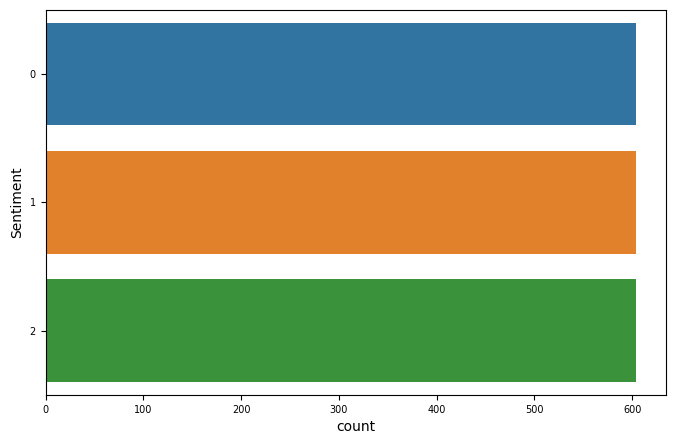

In [188]:
sns.countplot(y="Sentiment",data=df)

In [189]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
2,0,The international electronic industry company ...
415,0,A tinyurl link takes users to a scamming site ...
421,0,"Compared with the FTSE 100 index , which rose ..."
423,0,"Compared with the FTSE 100 index , which rose ..."
500,0,One of the challenges in the oil production in...
...,...,...
4534,2,To ensure low operational cost for radio netwo...
4536,2,Key shareholders of Finnish IT services provid...
4773,2,"According to the company , its operating profi..."
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent t...


### Determinig the sentiment using TextBlob Polarity

In [190]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', '')
    ReviewText = ReviewText.str.replace(',', '')
    ReviewText = ReviewText.str.replace('--', '')    
    ReviewText = ReviewText.str.replace('`', '')    

    return ReviewText
df['Review Text'] = preprocess(df['Sentence'])

df['polarity'] = df['Sentence'].map(lambda text: TextBlob(text).sentiment.polarity)
df['sentence_len'] = df['Review Text'].astype(str).apply(len)
df['word_count'] = df['Sentence'].apply(lambda x: len(str(x).split()))

In [191]:
df = df.drop(["sentence_len", "Sentence","word_count","polarity" ] , axis =1)


### Sentiment Analysis using BERT

In [192]:
from sklearn.model_selection import train_test_split
X_features = df["Review Text"]
Y_features = df["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Sentiment.values, test_size=0.2, random_state=42, shuffle=True)

In [193]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [194]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby([ 'Sentiment', 'data_type']).count()
df = df.rename(columns={'Review Text': 'Sentence'})
df[df.data_type == 'train'].Sentence.values


array(['The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers  the daily Postimees reported .',
       'A tinyurl link takes users to a scamming site promising that users can earn thousands of dollars by becoming a Google ( NASDAQ : GOOG ) Cash advertiser .',
       'Compared with the FTSE 100 index  which rose 36.7 points ( or 0.6 % ) on the day  this was a relative price change of -0.2 % .',
       ...,
       'According to the company  its operating profit  excluding non-recurring items  in the fourth quarter of 2009 was significantly better than expected  and also better than the figures for the fourth quarter of 2008 .',
       'Danske Bank A-S DANSKE DC jumped 3.7 percent to 133.4 kroner  rebounding from yesterday s 3.5 percent slide .',
       'The 2015 target for net sales has been set at EUR 1bn and the target for return on investment at

In [205]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 100,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus( df[df.data_type == 'val'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 100,
                                                return_tensors = 'pt')

In [206]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Sentiment.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].Sentiment.values)
     

In [207]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [208]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = batch_size) #since we don't have to do backpropagation for this step

In [209]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-7) #2e-5 > 5e-5
                 
epochs = 8

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps =len(dataloader_train)*epochs)


In [210]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [201]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [202]:
#accuracy score
def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')

In [203]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [211]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLP/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/3 [37:06<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



 33%|███▎      | 1/3 [40:02<1:20:05, 2402.83s/it]

Validation loss: 0.6717540278382923
F1 Score (weighted): 0.7384179171728579



 33%|███▎      | 1/3 [1:16:42<1:20:05, 2402.83s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 67%|██████▋   | 2/3 [1:19:39<39:47, 2387.19s/it]  

Validation loss: 0.47046577962844266
F1 Score (weighted): 0.817587773983123



 67%|██████▋   | 2/3 [1:57:45<39:47, 2387.19s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



100%|██████████| 3/3 [2:00:43<00:00, 2414.65s/it]

Validation loss: 0.42946075955810753
F1 Score (weighted): 0.8295515603719594


In [212]:
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 46/46 [02:56<00:00,  3.84s/it]


In [213]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:123/128
 -> 0.9609375
Accuracy:82/107
 -> 0.7663551401869159
Accuracy:97/128
 -> 0.7578125


###Testing with the Arabic Dataset.


1.   Load the model.
2.   Load the dataset.
3.   Translate the dataset and preprocess it.
4.   Test using the model.



In [214]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [215]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [42]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)
                                                      
path = F"/content/gdrive/MyDrive/NLP/BERT_ft_epoch3.model"
model.load_state_dict(torch.load(path))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [43]:
from transformers import TextClassificationPipeline

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [6]:
import pandas as pd
import numpy as np
dfTest = pd.read_csv('/content/gdrive/MyDrive/NLP/labelled.csv' ,engine="python")
dfTest

,Sentence,id,label
0,انخفضت أرباح شركة الخليج للمواشي إلى 12،1 مليو...,36,negative
1,تناقش عمومية شركة أرامكس يوم 21 مارس توزيع أرب...,1962,positive
2,حققت العين الأهلية للتأمين أرباحاً بلغت 2 .50 ...,2838,positive
3,ارتفعت أرباح اسمنت أم القيوين بنسبة 30% إلى 7 ...,1599,positive
4,قررت الجمعية العمومية لشركة صناعات أسمنت الفجي...,1528,negative
5,ينعقد يوم الثلاثاء المقبل اجتماع مجلس إدارة بن...,3615,neutral
6,"دبي ""الخليج"":بلغت أرباح شركة ""دبي للتطوير"" في ...",5050,positive
7,أعلنت شركة العين الأهلية للتأمين عن أنها ستفصح...,220,neutral
8,يعتزم بنك إتش إس بي سي إنشاء صندوق بقيمة 100 م...,2101,positive
9,يعقد اجتماع مجلس الإدارة للشركة العربية للصناع...,4559,neutral


In [7]:
from transformers import MarianTokenizer, MarianMTModel
mname = "Helsinki-NLP/opus-mt-tc-big-ar-en"
tokenizer = MarianTokenizer.from_pretrained(mname)
model_translate = MarianMTModel.from_pretrained(mname)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [8]:
translated = []
for i in range(len(dfTest)):
  input = dfTest['Sentence'][i]
  translated_tokens = model_translate.generate(**tokenizer.prepare_seq2seq_batch([input], return_tensors="pt"))
  translated_text = [tokenizer.decode(t, skip_special_tokens=True) for t in translated_tokens]
  translated.append(translated_text[0])
dfTest['English'] = translated

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [9]:
dfTest = dfTest.drop(["Sentence","id"] , axis =1)
dfTest = dfTest.rename(columns={'label': 'Sentiment', 'English':'Sentence'})
dfTest['Sentiment'] = dfTest['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
dfTest

,Sentiment,Sentence
0,0,The profits of the Gulf Livestock Company fell...
1,2,Aramex to discuss cash dividend of 16% for 2016
2,2,Al Ain Al Ahlia Insurance achieved a profit of...
3,2,Umm Al Quwain Cement’s profit increased by 30%...
4,0,The General Assembly of Fujairah Cement Indust...
5,1,"Next Tuesday, ADCB’s Board of Directors will m..."
6,2,"Dubai: Last year, Dubai Development Company pr..."
7,1,Al Ain Al Ahlia Insurance Company announced th...
8,2,HSBC to set up $100 million fund to support UA...
9,1,The meeting of the Board of Directors of the A...


In [52]:
#encode Arabic Testing set
encoded_data_val_Arabic = tokenizer.batch_encode_plus( dfTest.Sentence.values,
                                                       add_special_tokens = True,
                                                       return_attention_mask = True,
                                                       pad_to_max_length = True,
                                                       max_length = 80,
                                                       return_tensors = 'pt', 
                                                       truncation=True)

In [53]:
input_ids_val_Arabic = encoded_data_val_Arabic['input_ids']
attention_masks_val_Arabic = encoded_data_val_Arabic['attention_mask']
labels_val_Arabic = torch.tensor(dfTest.Sentiment.values)

In [54]:
from torch.utils.data import TensorDataset

#Arabic Validation set
dataset_val_Arabic = TensorDataset(input_ids_val_Arabic, 
                                   attention_masks_val_Arabic, 
                                   labels_val_Arabic)

In [55]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3



#Arabic validation set
dataloader_val_Arabic = DataLoader(dataset_val_Arabic,
                                   sampler = RandomSampler(dataset_val_Arabic),
                                   batch_size = 3) #since we don't have to do backpropagation for this step

In [56]:
#accuracy score
def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')

In [57]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in tqdm(dataloader_val):

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [58]:
from tqdm import tqdm

_,predictions, true_vals = evaluate(dataloader_val_Arabic)

100%|██████████| 12/12 [00:41<00:00,  3.47s/it]


In [59]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:9/9
 -> 1.0
Accuracy:12/12
 -> 1.0
Accuracy:11/15
 -> 0.7333333333333333


In [50]:
# preprocess the sentence
correct = 0
false = 0
positive = 0
negative = 0
neutral = 0
for i in range(len(dfTest)):
  row = dfTest.iloc[i]
  sentence = row['Sentence']
  label = row['Sentiment']
  input_ids = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)).unsqueeze(0)
  attention_mask = torch.tensor([1] * input_ids.shape[1]).unsqueeze(0)

  # get the predicted sentiment label
  with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      _, predicted_label = torch.max(outputs[0], dim=1)
  print(sentence, predicted_label,label)
  if(label == 0):
    negative = negative + 1
  elif(label == 1):
    neutral = neutral + 1
  elif(label == 2):
    positive = positive + 1
  if(predicted_label == label):
    correct = correct + 1
  else:
    false = false + 1
  print(correct,false)

The profits of the Gulf Livestock Company fell to 12.1 million dirhams in 2010, compared to 27.6 million dirhams in 2009. tensor([0]) 0
1 0
Aramex to discuss cash dividend of 16% for 2016 tensor([2]) 2
2 0
Al Ain Al Ahlia Insurance achieved a profit of AED 2.50 million in 2012 compared to AED 2.53 million in 2011. tensor([2]) 2
3 0
Umm Al Quwain Cement’s profit increased by 30% to AED 7.22 million in the first quarter of this year tensor([2]) 2
4 0
The General Assembly of Fujairah Cement Industries decided not to distribute cash dividends or shares for the year 2010. tensor([0]) 0
5 0
Next Tuesday, ADCB’s Board of Directors will meet to discuss some general matters. tensor([1]) 1
6 0
Dubai: Last year, Dubai Development Company profit reached AED 735,000 compared to AED 9,444,000 in 2013 tensor([2]) 2
7 0
Al Ain Al Ahlia Insurance Company announced that it will disclose its financial results for the third quarter of 2011 on 31/10/2011 tensor([1]) 1
8 0
HSBC to set up $100 million fund t

In [51]:
print("Accuracy of testing = ", 100 * correct / (correct + false)) 
print(negative,positive,neutral) 

Accuracy of testing =  88.88888888888889
9 15 12
